<a href="https://colab.research.google.com/github/syahputra21/Deep-Learning_Tugas-2_Klasifikasi-Pisau/blob/main/Tugas2_Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Path ke dataset di Google Drive
dataset_path = '/content/drive/MyDrive/Dataset_Pisau'  # Ganti dengan path dataset Anda

# Periksa apakah dataset ada
if not os.path.exists(dataset_path):
    raise Exception(f"Dataset tidak ditemukan di {dataset_path}. Pastikan path benar.")

# Kelas-kelas yang ada
class_names = sorted(os.listdir(dataset_path))
num_classes = len(class_names)

print(f"Ditemukan {num_classes} kelas: {class_names}")
print("Contoh file di kelas pertama:", os.listdir(os.path.join(dataset_path, class_names[0]))[:5])

Ditemukan 4 kelas: ['Cutter', 'Pen_Cutter', 'Pisau Dapur', 'Pisau_Daging']
Contoh file di kelas pertama: ['  (375).jpg', '  (373).jpg', '  (370).jpg', '  (376).jpg', '  (372).jpg']


In [3]:
# Parameter
batch_size = 32
img_height = 224  # MobileNetV2 default input size
img_width = 224
validation_split = 0.2  # 20% untuk validasi

# Data generator dengan augmentasi untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split
)

# Data generator untuk validasi (hanya rescaling)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Training dataset
train_ds = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation dataset
val_ds = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 968 images belonging to 4 classes.
Found 242 images belonging to 4 classes.


In [4]:
# Load MobileNetV2 base model tanpa top layer dan dengan weights imagenet
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze base model
base_model.trainable = False

# Bangun model lengkap
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom callback untuk menampilkan semua metrik
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print(f"{'Epoch':<7}{'Train Loss':<12}{'Train Acc':<12}{'Val Loss':<12}{'Val Acc':<12}")
        print("-" * 55)

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss', 0)
        train_acc = logs.get('accuracy', 0)
        val_loss = logs.get('val_loss', 0)
        val_acc = logs.get('val_accuracy', 0)
        print(f"{epoch + 1:<7}{train_loss:<12.4f}{train_acc:<12.4f}{val_loss:<12.4f}{val_acc:<12.4f}")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Training
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, TrainingProgressCallback()],
    verbose=1  # Tetap pertahankan progress bar default
)

# Menampilkan nilai terbaik
best_epoch = np.argmin(history.history['val_loss'])
print("\nBest Epoch Summary:")
print(f"{'Epoch':<7}{'Train Loss':<12}{'Train Acc':<12}{'Val Loss':<12}{'Val Acc':<12}")
print("-" * 55)
print(f"{best_epoch + 1:<7}"
      f"{history.history['loss'][best_epoch]:<12.4f}"
      f"{history.history['accuracy'][best_epoch]:<12.4f}"
      f"{history.history['val_loss'][best_epoch]:<12.4f}"
      f"{history.history['val_accuracy'][best_epoch]:<12.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch  Train Loss  Train Acc   Val Loss    Val Acc     
-------------------------------------------------------
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2923 - loss: 1.7148

1      1.6607      0.2769      1.3732      0.3347      
31/31 ━━━━━━━━━━━━━━━━━━━━ 386s 12s/step - accuracy: 0.2919 - loss: 1.7132 - val_accuracy: 0.3347 - val_loss: 1.3732
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.3468 - loss: 1.4327

2      1.3676      0.3791      1.1751      0.4587      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.3478 - loss: 1.4307 - val_accuracy: 0.4587 - val_loss: 1.1751
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.4734 - loss: 1.2266

3      1.2061      0.4804      1.0145      0.5992      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 673ms/step - accuracy: 0.4736 - loss: 1.2260 - val_accuracy: 0.5992 - val_loss: 1.0145
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.5481 - loss: 1.0662

4      1.0450      0.5682      0.8857      0.6612      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.5487 - loss: 1.0655 - val_accuracy: 0.6612 - val_loss: 0.8857
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6346 - loss: 0.9369

5      0.9329      0.6271      0.7842      0.7314      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 681ms/step - accuracy: 0.6343 - loss: 0.9368 - val_accuracy: 0.7314 - val_loss: 0.7842
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.6977 - loss: 0.8506

6      0.8394      0.6860      0.7050      0.7975      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 677ms/step - accuracy: 0.6973 - loss: 0.8502 - val_accuracy: 0.7975 - val_loss: 0.7050
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.6936 - loss: 0.8212

7      0.7929      0.7066      0.6368      0.8388      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 706ms/step - accuracy: 0.6940 - loss: 0.8203 - val_accuracy: 0.8388 - val_loss: 0.6368
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.7633 - loss: 0.7011

8      0.7041      0.7676      0.5829      0.8512      
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 737ms/step - accuracy: 0.7635 - loss: 0.7012 - val_accuracy: 0.8512 - val_loss: 0.5829
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.7871 - loss: 0.6435

9      0.6450      0.7862      0.5383      0.8595      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 674ms/step - accuracy: 0.7870 - loss: 0.6436 - val_accuracy: 0.8595 - val_loss: 0.5383
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.7902 - loss: 0.6334

10     0.6185      0.7986      0.5012      0.8760      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.7904 - loss: 0.6329 - val_accuracy: 0.8760 - val_loss: 0.5012
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.8269 - loss: 0.5712

11     0.5833      0.8161      0.4684      0.8926      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.8266 - loss: 0.5716 - val_accuracy: 0.8926 - val_loss: 0.4684
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8295 - loss: 0.5621

12     0.5481      0.8316      0.4403      0.9008      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 675ms/step - accuracy: 0.8295 - loss: 0.5617 - val_accuracy: 0.9008 - val_loss: 0.4403
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8413 - loss: 0.5346

13     0.5271      0.8399      0.4161      0.9050      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.8412 - loss: 0.5344 - val_accuracy: 0.9050 - val_loss: 0.4161
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8418 - loss: 0.4938

14     0.4966      0.8419      0.3939      0.9091      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 671ms/step - accuracy: 0.8418 - loss: 0.4939 - val_accuracy: 0.9091 - val_loss: 0.3939
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8506 - loss: 0.4727

15     0.4740      0.8471      0.3764      0.9174      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 732ms/step - accuracy: 0.8505 - loss: 0.4728 - val_accuracy: 0.9174 - val_loss: 0.3764
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.8540 - loss: 0.475116     0.4664      0.8605      0.3596      0.9132      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.8542 - loss: 0.4748 - val_accuracy: 0.9132 - val_loss: 0.3596
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8370 - loss: 0.478817     0.4404      0.8616      0.3452      0.9132      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - accuracy: 0.8378 - loss: 0.4776 - val_accuracy: 0.9132 - val_loss: 0.3452
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8670 - loss: 0.4417

18     0.4237      0.8719      0.3310      0.9298      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.8672 - loss: 0.4412 - val_accuracy: 0.9298 - val_loss: 0.3310
Epoch 19/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.8696 - loss: 0.415019     0.4000      0.8843      0.3200      0.9256      
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 764ms/step - accuracy: 0.8701 - loss: 0.4146 - val_accuracy: 0.9256 - val_loss: 0.3200
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8694 - loss: 0.4154

20     0.3876      0.8802      0.3111      0.9380      
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 711ms/step - accuracy: 0.8698 - loss: 0.4145 - val_accuracy: 0.9380 - val_loss: 0.3111
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8957 - loss: 0.366321     0.3636      0.8967      0.3003      0.9339      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.8957 - loss: 0.3663 - val_accuracy: 0.9339 - val_loss: 0.3003
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8782 - loss: 0.399722     0.3835      0.8853      0.2923      0.9380      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 684ms/step - accuracy: 0.8785 - loss: 0.3992 - val_accuracy: 0.9380 - val_loss: 0.2923
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.8834 - loss: 0.3658

23     0.3622      0.8874      0.2847      0.9421      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 703ms/step - accuracy: 0.8835 - loss: 0.3657 - val_accuracy: 0.9421 - val_loss: 0.2847
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8879 - loss: 0.350024     0.3319      0.8946      0.2766      0.9421      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 666ms/step - accuracy: 0.8881 - loss: 0.3495 - val_accuracy: 0.9421 - val_loss: 0.2766
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8967 - loss: 0.309625     0.3307      0.8946      0.2695      0.9421      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 678ms/step - accuracy: 0.8966 - loss: 0.3103 - val_accuracy: 0.9421 - val_loss: 0.2695
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9143 - loss: 0.3113

26     0.3155      0.9163      0.2631      0.9463      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 666ms/step - accuracy: 0.9144 - loss: 0.3114 - val_accuracy: 0.9463 - val_loss: 0.2631
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.8970 - loss: 0.332727     0.3296      0.9008      0.2577      0.9421      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 680ms/step - accuracy: 0.8971 - loss: 0.3326 - val_accuracy: 0.9421 - val_loss: 0.2577
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.8828 - loss: 0.3595

28     0.3405      0.8977      0.2502      0.9587      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - accuracy: 0.8833 - loss: 0.3590 - val_accuracy: 0.9587 - val_loss: 0.2502
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9034 - loss: 0.304229     0.3010      0.9050      0.2453      0.9504      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 667ms/step - accuracy: 0.9035 - loss: 0.3041 - val_accuracy: 0.9504 - val_loss: 0.2453
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9194 - loss: 0.285130     0.2952      0.9091      0.2402      0.9504      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 662ms/step - accuracy: 0.9190 - loss: 0.2854 - val_accuracy: 0.9504 - val_loss: 0.2402
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9188 - loss: 0.2685

31     0.2764      0.9122      0.2346      0.9628      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 679ms/step - accuracy: 0.9186 - loss: 0.2688 - val_accuracy: 0.9628 - val_loss: 0.2346
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9107 - loss: 0.295132     0.3048      0.9039      0.2300      0.9628      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 656ms/step - accuracy: 0.9105 - loss: 0.2954 - val_accuracy: 0.9628 - val_loss: 0.2300
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9186 - loss: 0.268033     0.2869      0.9060      0.2260      0.9587      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.9182 - loss: 0.2686 - val_accuracy: 0.9587 - val_loss: 0.2260
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.9031 - loss: 0.295834     0.2838      0.9122      0.2217      0.9587      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 680ms/step - accuracy: 0.9034 - loss: 0.2955 - val_accuracy: 0.9587 - val_loss: 0.2217
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 590m

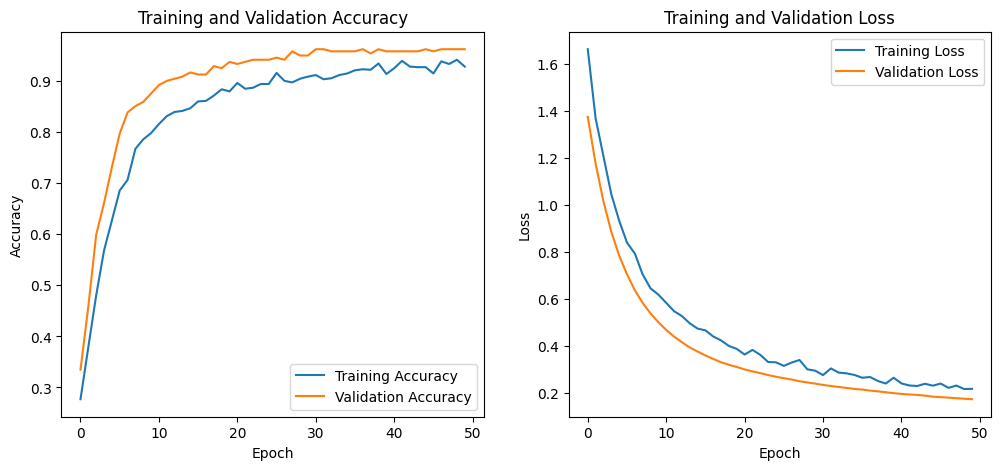

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.9581 - loss: 0.1776

Validation Accuracy: 0.9628


In [6]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluasi pada validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy: {val_acc:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 585ms/step

Classification Report:
              precision    recall  f1-score   support

      Cutter       0.98      0.94      0.96        62
  Pen_Cutter       0.94      0.97      0.95        60
 Pisau Dapur       0.95      0.98      0.97        60
Pisau_Daging       0.98      0.97      0.97        60

    accuracy                           0.96       242
   macro avg       0.96      0.96      0.96       242
weighted avg       0.96      0.96      0.96       242



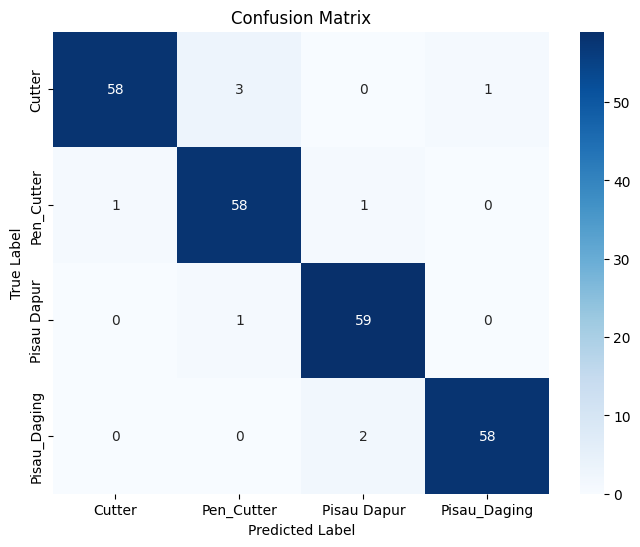

In [7]:
# Prediksi pada validation set
val_ds.reset()  # Reset generator
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_ds.classes

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Saving PISAU-DAPUR-KAYU-BESAR-LANCIP.jpg to PISAU-DAPUR-KAYU-BESAR-LANCIP.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


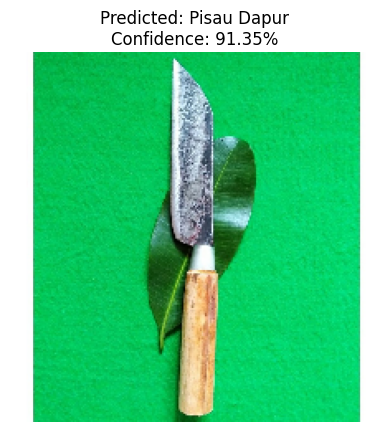


Probabilitas per kelas:
Cutter: 2.95%
Pen_Cutter: 4.05%
Pisau Dapur: 91.35%
Pisau_Daging: 1.65%


In [8]:
# Cell untuk Upload Gambar dan Prediksi
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_uploaded_image():
    # Upload gambar
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Load dan preprocess gambar
        img_path = '/content/' + filename
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Prediksi
        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions)]
        confidence = np.max(predictions) * 100

        # Tampilkan hasil
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
        plt.show()

        # Tampilkan probabilitas semua kelas
        print("\nProbabilitas per kelas:")
        for i, class_name in enumerate(class_names):
            print(f"{class_name}: {predictions[0][i]*100:.2f}%")

# Jalankan fungsi prediksi
predict_uploaded_image()

In [9]:
# Simpan model akhir
model.save('/content/drive/MyDrive/final_model.h5')
print("Model disimpan di Google Drive")

Model disimpan di Google Drive
